In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lip-reading1/data/s1/bwam9s.mpg
/kaggle/input/lip-reading1/data/s1/lgbm4p.mpg
/kaggle/input/lip-reading1/data/s1/bbizzn.mpg
/kaggle/input/lip-reading1/data/s1/srwo6n.mpg
/kaggle/input/lip-reading1/data/s1/bgbu3s.mpg
/kaggle/input/lip-reading1/data/s1/pwax6p.mpg
/kaggle/input/lip-reading1/data/s1/srwb8n.mpg
/kaggle/input/lip-reading1/data/s1/sgic1a.mpg
/kaggle/input/lip-reading1/data/s1/sgbp6p.mpg
/kaggle/input/lip-reading1/data/s1/sbwo2p.mpg
/kaggle/input/lip-reading1/data/s1/srit9s.mpg
/kaggle/input/lip-reading1/data/s1/sgio6n.mpg
/kaggle/input/lip-reading1/data/s1/srah6p.mpg
/kaggle/input/lip-reading1/data/s1/prip2p.mpg
/kaggle/input/lip-reading1/data/s1/sbinzp.mpg
/kaggle/input/lip-reading1/data/s1/bgaa6n.mpg
/kaggle/input/lip-reading1/data/s1/pgak2n.mpg
/kaggle/input/lip-reading1/data/s1/pgwe7s.mpg
/kaggle/input/lip-reading1/data/s1/bgit7a.mpg
/kaggle/input/lip-reading1/data/s1/pbwp6n.mpg
/kaggle/input/lip-reading1/data/s1/bgwb4n.mpg
/kaggle/input/lip-reading1/data/s1

In [2]:
!pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 36.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp310-cp310-linux_x86_64.whl size=3829163 sha256=ff8dbca84fe54b372a91565ab47253ca9012829632fffe1dc4a8bd825a768716
  Stored in directory: /root/.cache/pip/wheels/9b/e2/80/888fdc098db86b463ff0c83ae5e5ca151889e901bc1e9a3a11
Successfully built dlib


In [3]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import imageio
from typing import List

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
device =  tf.config.list_physical_devices('GPU')

In [5]:
device

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
try:
    tf.config.experimental.set_memory_growth(device, True)
except:
    pass

# SETTING THE DATA LOADER

In [7]:
LIP_MARGIN = 0.3
RESIZE = (140,46)

face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("/kaggle/input/dlib-shape-detector/detector/shape_predictor_68_face_landmarks.dat")

In [8]:
def shape_to_list(shape):
    
    coords = []
    for i in range(0, 68):
        coords.append((shape.part(i).x, shape.part(i).y))
    
    return coords

In [9]:
def load_video(path:str) -> List[float]:
    
    vid = cv2.VideoCapture(path)
    
    frame_buffer = []
    frame_buffer_color = []
    
    while(True):
    
        success, frame = vid.read()                     # Read frame
        if not success: break                           # Break if no frame to read left
        
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)   # Convert image into grayscale
        frame_buffer.append(gray)                       # Add gray-scale image to the frame buffer
        frame_buffer_color.append(frame)                # Add color image to the color frame buffer
    
    vid.release()
    
    landmark_buffer = []    # Used to store the Facial Landmarks
    
    for (i, image) in enumerate(frame_buffer):
        
        face_rects = face_detector(image,1)    #detect the faces in the frame
        
        if len(face_rects) < 1:
            print("No face detected")
            break
            
        if len(face_rects) > 1:
            print("Multiple faces detected")
            break
            
        rect = face_rects[0]
        
        landmark = landmark_detector(image, rect)    # used to detect landmarks
        landmark = shape_to_list(landmark)           # converting to list as dlib library output is in the 'shape' type
        landmark_buffer.append(landmark)            # Add the landmarks to the buffer
        
    cropped_buffer = []     # used to store the Lip landmarks
        
    for (i, landmark) in enumerate(landmark_buffer):
            
        lip_landmark = landmark[48:68] # landmarks corresponding to lips
        
        lip_x = sorted(lip_landmark,key = lambda pointx: pointx[0])     # Lip landmark sorted for determining lip region
        lip_y = sorted(lip_landmark, key = lambda pointy: pointy[1])    
        
        x_add = int((-lip_x[0][0]+lip_x[-1][0])*LIP_MARGIN)                     # Determine Margins for lip-only image
        y_add = int((-lip_y[0][1]+lip_y[-1][1])*LIP_MARGIN)
        
        crop_pos = (lip_x[0][0]-x_add, lip_x[-1][0]+x_add, lip_y[0][1]-y_add, lip_y[-1][1]+y_add)
        cropped = frame_buffer_color[i][crop_pos[2]:crop_pos[3],crop_pos[0]:crop_pos[1]]        # Crop image
        cropped = cv2.resize(cropped,(RESIZE[0],RESIZE[1]),interpolation=cv2.INTER_CUBIC)       # Resize the image to desired shape
        
        cropped = tf.image.rgb_to_grayscale(cropped)
        
        cropped_buffer.append(cropped)
        
    
    mean = tf.math.reduce_mean(cropped_buffer)
    std = tf.math.reduce_std(tf.cast(cropped_buffer, tf.float32))
    
    return tf.cast((cropped_buffer - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['a','m','e','y'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 1, 13,  5, 25])>

In [14]:
num_to_char([ 1, 13,  5, 25]).numpy()

array([b'a', b'm', b'e', b'y'], dtype=object)

In [15]:
def load_alignments(path:str) -> List[str]:
    
    with open(path, 'r') as f:
        lines = f.readlines()
        
    tokens = []
    
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            
            tokens = [*tokens, ' ', line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path:str):
    path = bytes.decode(path.numpy())
    
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/kaggle','input','lip-reading1','data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('/kaggle','input','lip-reading1','data', 'alignments', 's1', f'{file_name}.align')
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
test_path = './data/s1/bbaf2n.mpg'

In [18]:
test_path = test_path.split('/')[-1].split('.')[0]
video_path = os.path.join('/kaggle','input','lip-reading1','data', 's1', f'{test_path}.mpg')

print("Video Path: ", video_path)

Video Path:  /kaggle/input/lip-reading1/data/s1/bbaf2n.mpg


In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [21]:
frames.shape

TensorShape([75, 46, 140, 1])

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [23]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# CREATING THE DATA PIPELINE

In [24]:
def filter_files(file_path):
    
    files_to_remove = ['brwa4p.mpg', 'pbio7a.mpg', 'bwwuzn.mpg', 'sran9s.mpg', 'brwg8p.mpg', 'lrarzn.mpg', 'sbbh4p.mpg', 'Thumbs.db', 'pbwx1s.mpg', 'prii9a.mpg', 'lgbf8n.mpg', 'bbizzn.mpg']  # file names to remove
    file_name = tf.strings.split(file_path, os.path.sep)[-1]  # Extract the file name from the path
    
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(file_name, files_to_remove)))

In [25]:
database = tf.data.Dataset.list_files('/kaggle/input/lip-reading1/data/s1/*.mpg')

k=0
for i in database:
    k=k+1
    if k==1:
        print(tf.strings.split(i, os.path.sep)[-1])

print(k)
print("************************")

database1 = database.filter(filter_files)

k=0
for i in database1:
    k=k+1
    if k==1:
        print(tf.strings.split(i, os.path.sep)[-1])
        
print(k)
print("************************")

tf.Tensor(b'bbbm2p.mpg', shape=(), dtype=string)
1000
************************
tf.Tensor(b'prwq4p.mpg', shape=(), dtype=string)
989
************************


In [26]:
def filter_files(file_path):
    
    files_to_remove = ['brwa4p.mpg', 'pbio7a.mpg', 'bwwuzn.mpg', 'sran9s.mpg', 'brwg8p.mpg', 'lrarzn.mpg', 'sbbh4p.mpg', 'Thumbs.db', 'pbwx1s.mpg', 'prii9a.mpg', 'lgbf8n.mpg', 'bbizzn.mpg']  # file names to remove
    file_name = tf.strings.split(file_path, os.path.sep)[-1]  # Extract the file name from the path
    
    return tf.math.logical_not(tf.reduce_any(tf.math.equal(file_name, files_to_remove)))

In [27]:
data = tf.data.Dataset.list_files('/kaggle/input/lip-reading1/data/s1/*.mpg')  # get the files stored in the directory
data = data.filter(filter_files)
data = data.shuffle(500, reshuffle_each_iteration=False)  # shuffle the data for improved accuracy with parameter=500 
data = data.map(mappable_function)  # apply mappable function to each video to get the cropped video of the lips and its alignments
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))  #take a batch of videos
data = data.prefetch(tf.data.AUTOTUNE)  # prefetch to reduce run-time

# for splitting into train and test 

train = data.take(450)
test = data.skip(450)

In [28]:
test

<_SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [29]:
frames, alignments = data.as_numpy_iterator().next()

In [30]:
len(frames)

2

In [31]:
sample = data.as_numpy_iterator()

In [32]:
val = sample.next();

In [33]:
val[0].shape  # 2 videos, each of 75 frames, having 46X140 pixels in grayscale 

(2, 75, 46, 140, 1)

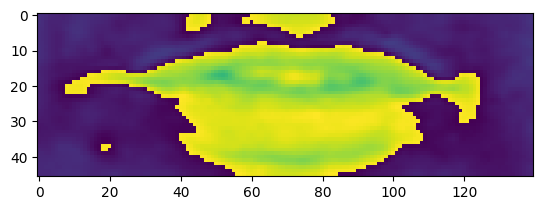

In [34]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][40])

In [35]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white in o one soon'>

# DESIGN THE DEEP NEURAL NET

In [36]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [37]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [38]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [40]:
5*17*75

6375

In [41]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [42]:
yhat.shape

(2, 75, 41)

In [43]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([ 5, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39,  0,  0,  0,  0,  0,  0,  0, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
       39, 39, 39, 39, 39, 39, 39])>

In [44]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'e                                                                   '>

In [45]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'e                                                                   '>

In [46]:
model.input_shape

(None, 75, 46, 140, 1)

In [47]:
model.output_shape

(None, 75, 41)

# SETUP TRAINING LOOP

In [48]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [49]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [50]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [51]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [52]:
checkpoint_callback = ModelCheckpoint(os.path.join('/kaggle','working','models','checkpoint'), monitor='loss', save_weights_only=True) 

In [53]:
schedule_callback = LearningRateScheduler(scheduler)

In [54]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[schedule_callback, example_callback], steps_per_epoch=100)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 105.6585